# Setup environment

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pytz import timezone
import copy
import pathlib

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

try:
    import lightgbm as lgb
except:
    print("lightgbm is not installed")

DATA_DIR = "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/merged-data/by-station"
STATION_IDS = [211, 212, 213, 214, 215, 216]

BASE_FEATURE_COLS = [
    "NO2_quantrac",
    "PM25_quantrac",
    "O3_quantrac",
    "CO_quantrac",
    "SO2_quantrac",
    "Temperature_quantrac",
    "Humid_quantrac",
]

# Define lag and rolling windows for feature engineering
LAG_STEPS = [3, 6, 12, 24]
ROLL_WINDOWS = [3, 6, 12, 24]

# Define horizon (= n_past = n_future)
HORIZONS = [1, 24, 48, 72]

RANDOM_STATE = 42

# Directory to save the results and meta data
LIGHTGBM_DIR = f"/le_thanh_van_118/workspace/hiep_workspace/lightgbm_results/{datetime.now(timezone('Asia/Saigon')).strftime('%Y_%m_%d-%H_%M_%S')}"
pathlib.Path(LIGHTGBM_DIR).mkdir(parents=True, exist_ok=True)
print(LIGHTGBM_DIR)
with open(os.path.join(LIGHTGBM_DIR, "CONFIGURATIONS.txt"), "w") as f:
    f.write(f"BASE_FEATURE_COLS: {BASE_FEATURE_COLS}\n")
    f.write(f"LAG_STEPS: {LAG_STEPS}\n")
    f.write(f"ROLL_WINDOWS: {ROLL_WINDOWS}\n")
    f.write(f"HORIZONS: {HORIZONS}\n")
    f.write(f"RANDOM_STATE: {RANDOM_STATE}\n")

/le_thanh_van_118/workspace/hiep_workspace/lightgbm_results/2025_12_11-17_09_15


# Load dataset

In [2]:
def load_station_csv(station_id, data_dir=DATA_DIR):
    csv_path = os.path.join(data_dir, f"{station_id}.csv")
    df = pd.read_csv(csv_path)

    # Convert to datetime
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").reset_index(drop=True)

    # Remove unncessary column
    if "Unnamed: 0" in df.columns:
        df = df.drop(columns=["Unnamed: 0"])

    # Add station_id column
    df["station_id"] = station_id
    return df

# Load dataset
dfs = []
for sid in STATION_IDS:
    df_sid = load_station_csv(sid, DATA_DIR)
    dfs.append(df_sid)
df_all = pd.concat(dfs, ignore_index=True)

# Sort data by station then date
df_all = df_all.sort_values(["station_id", "date"]).reset_index(drop=True)

# Remove uncessary features
df_all = df_all.loc[:, ["date"] + BASE_FEATURE_COLS + ["station_id"]]

print(df_all.shape)
print(df_all.columns)
df_all

(92966, 9)
Index(['date', 'NO2_quantrac', 'PM25_quantrac', 'O3_quantrac', 'CO_quantrac',
       'SO2_quantrac', 'Temperature_quantrac', 'Humid_quantrac', 'station_id'],
      dtype='object')


,date,NO2_quantrac,PM25_quantrac,O3_quantrac,CO_quantrac,SO2_quantrac,Temperature_quantrac,Humid_quantrac,station_id
0,2021-02-23 21:00:00,112.740762,15.604762,55.431381,90.000000,NaN,28.361905,63.188095,211
1,2021-02-23 22:00:00,112.366471,14.594118,58.197176,1200.603529,NaN,28.320588,63.773529,211
2,2021-02-23 23:00:00,112.700433,13.436667,55.029433,1177.897000,NaN,28.336667,64.205000,211
3,2021-02-24 00:00:00,112.480867,12.365000,54.767700,90.000000,NaN,28.305000,64.735000,211
4,2021-02-24 01:00:00,114.331500,11.636667,53.786200,90.000000,NaN,28.300000,65.188333,211
...,...,...,...,...,...,...,...,...,...
92961,2022-12-31 19:00:00,0.088233,41.450000,75.916667,2.087167,0.105667,27.690000,67.290000,216
92962,2022-12-31 20:00:00,0.083217,50.530000,66.116667,2.006500,0.104167,27.401667,68.026667,216
92963,2022-12-31 21:00:00,0.084300,55.055000,55.133333,2.418833,0.130167,27.603333,66.965000,216
92964,2022-12-31 22:00:00,0.066650,26.078333,46.750000,1.481500,0.075833,27.036667,63.361667,216


In [3]:
df_all.isnull().sum()

date                        0
NO2_quantrac            43684
PM25_quantrac           43043
O3_quantrac             47797
CO_quantrac             43760
SO2_quantrac            75946
Temperature_quantrac    52890
Humid_quantrac          52890
station_id                  0
dtype: int64

# Data preparation

## Drop missing

Output: df_dropped

In [4]:
df_dropped = df_all.dropna().reset_index(drop=True)
df_dropped

,date,NO2_quantrac,PM25_quantrac,O3_quantrac,CO_quantrac,SO2_quantrac,Temperature_quantrac,Humid_quantrac,station_id
0,2022-01-01 00:00:00,0.068981,18.414899,51.895318,1.238117,0.088139,29.117670,76.993087,216
1,2022-01-01 01:00:00,0.069400,19.490000,54.933333,0.930000,0.065333,26.695000,61.735000,216
2,2022-01-01 02:00:00,0.068500,18.080000,55.033333,0.788667,0.053167,26.260000,63.083333,216
3,2022-01-01 03:00:00,0.069683,16.393333,55.700000,0.732667,0.045167,25.830000,64.401667,216
4,2022-01-01 04:00:00,0.069417,15.293333,55.916667,0.717833,0.044500,25.580000,65.158333,216
...,...,...,...,...,...,...,...,...,...
7897,2022-12-31 19:00:00,0.088233,41.450000,75.916667,2.087167,0.105667,27.690000,67.290000,216
7898,2022-12-31 20:00:00,0.083217,50.530000,66.116667,2.006500,0.104167,27.401667,68.026667,216
7899,2022-12-31 21:00:00,0.084300,55.055000,55.133333,2.418833,0.130167,27.603333,66.965000,216
7900,2022-12-31 22:00:00,0.066650,26.078333,46.750000,1.481500,0.075833,27.036667,63.361667,216


## Update the STATION_IDS after dropping missing

In [5]:
STATION_IDS = list(df_dropped["station_id"].unique())
STATION_IDS

[216]

## Visualization

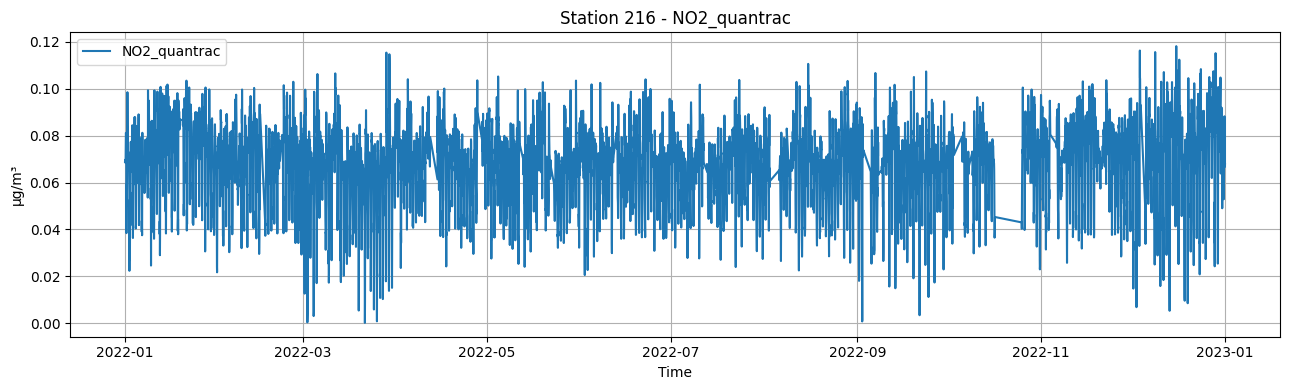

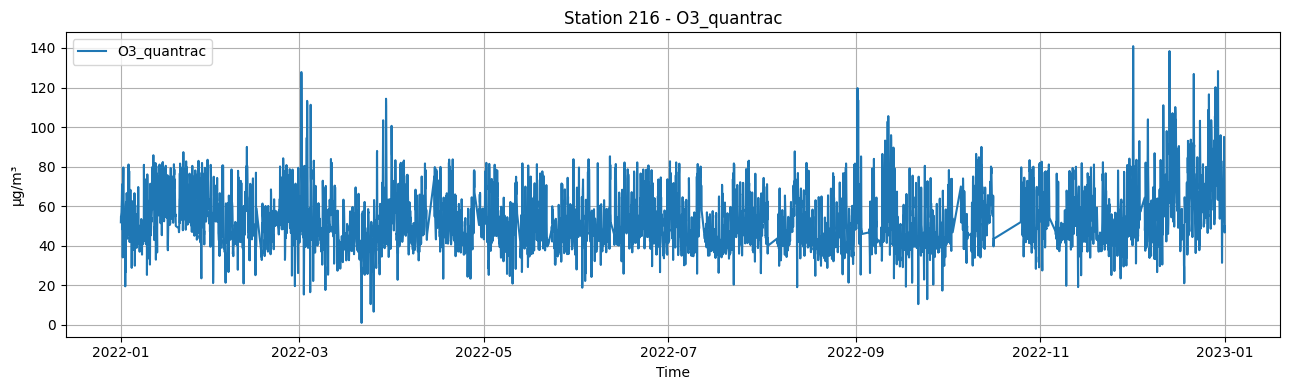

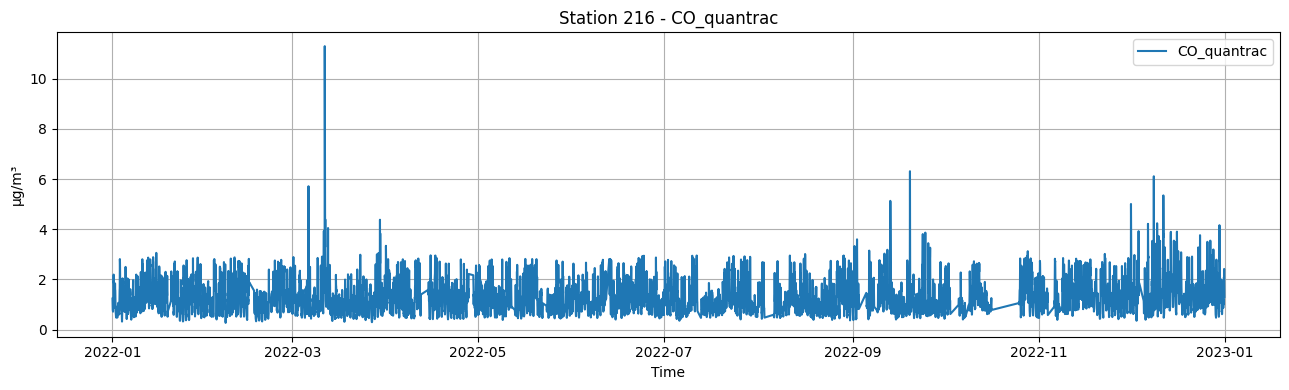

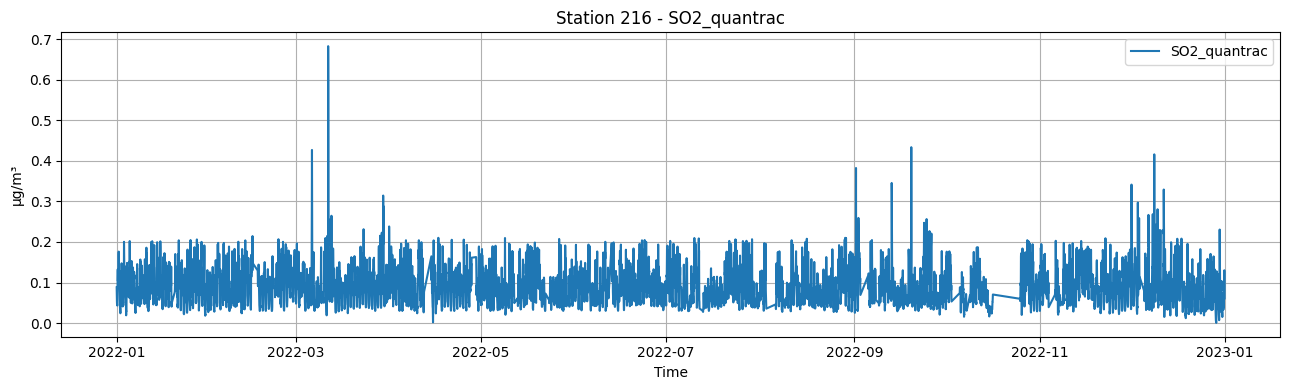

In [6]:
def plot_1_data(df, target_col, label, index, title, figsize=(13, 4)):
    plt.figure(figsize=figsize)
    plt.plot(index, df[target_col], label=label)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("µg/m³")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

for station in STATION_IDS:
    df_station = df_dropped[df_dropped["station_id"] == station]
    for target_col in df_station.columns:
        if target_col not in ["date", "station_id", "Temperature_quantrac", "Humid_quantrac", "PM25_quantrac"]:
            plot_1_data(df_station, target_col, target_col, df_station["date"], f"Station {station} - {target_col}")
            #plot_1_data(df_station, target_col, target_col, df_station.index, f"Station {station} - {target_col}")
    print("\n" + "=" * 150 + "\n")

## Convert ppm to ug/m3

Apply only to station 216, year 2022 on NO2, CO columns

Output: df_converted

In [7]:
df_converted = copy.deepcopy(df_dropped)
mask = (df_converted["station_id"] == 216) & (df_converted["date"] >= "2022-01-01")
df_converted.loc[mask, "NO2_quantrac"] = df_converted.loc[mask, "NO2_quantrac"].apply(lambda x: x * 1883.2)
df_converted.loc[mask, "CO_quantrac"] = df_converted.loc[mask, "CO_quantrac"].apply(lambda x: x * 1146.8)
df_converted.loc[mask, "SO2_quantrac"] = df_converted.loc[mask, "SO2_quantrac"].apply(lambda x: x * 2620)
df_converted

,date,NO2_quantrac,PM25_quantrac,O3_quantrac,CO_quantrac,SO2_quantrac,Temperature_quantrac,Humid_quantrac,station_id
0,2022-01-01 00:00:00,129.905143,18.414899,51.895318,1419.872305,230.924024,29.117670,76.993087,216
1,2022-01-01 01:00:00,130.694080,19.490000,54.933333,1066.524000,171.173333,26.695000,61.735000,216
2,2022-01-01 02:00:00,128.999200,18.080000,55.033333,904.442933,139.296667,26.260000,63.083333,216
3,2022-01-01 03:00:00,131.227653,16.393333,55.700000,840.222133,118.336667,25.830000,64.401667,216
4,2022-01-01 04:00:00,130.725467,15.293333,55.916667,823.211267,116.590000,25.580000,65.158333,216
...,...,...,...,...,...,...,...,...,...
7897,2022-12-31 19:00:00,166.161013,41.450000,75.916667,2393.562733,276.846667,27.690000,67.290000,216
7898,2022-12-31 20:00:00,156.713627,50.530000,66.116667,2301.054200,272.916667,27.401667,68.026667,216
7899,2022-12-31 21:00:00,158.753760,55.055000,55.133333,2773.918067,341.036667,27.603333,66.965000,216
7900,2022-12-31 22:00:00,125.515280,26.078333,46.750000,1698.984200,198.683333,27.036667,63.361667,216


## Visualization after converting unit

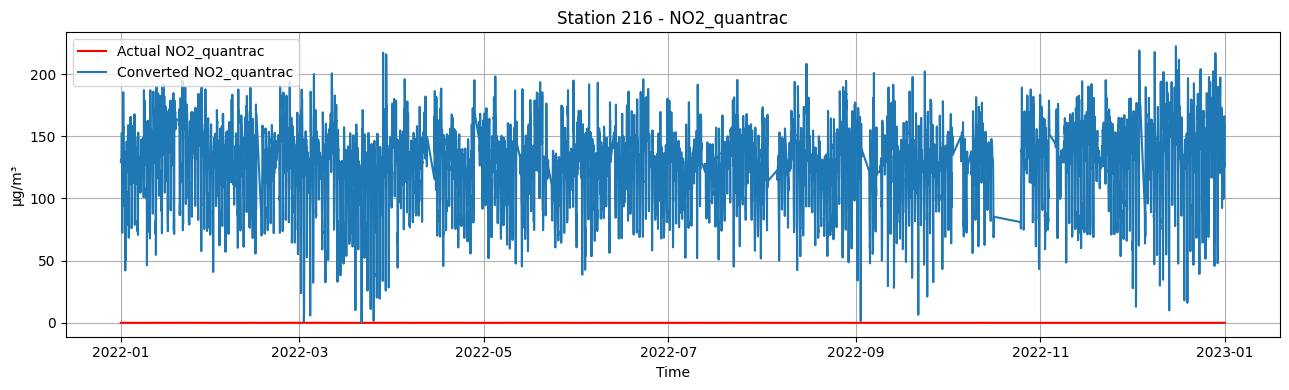

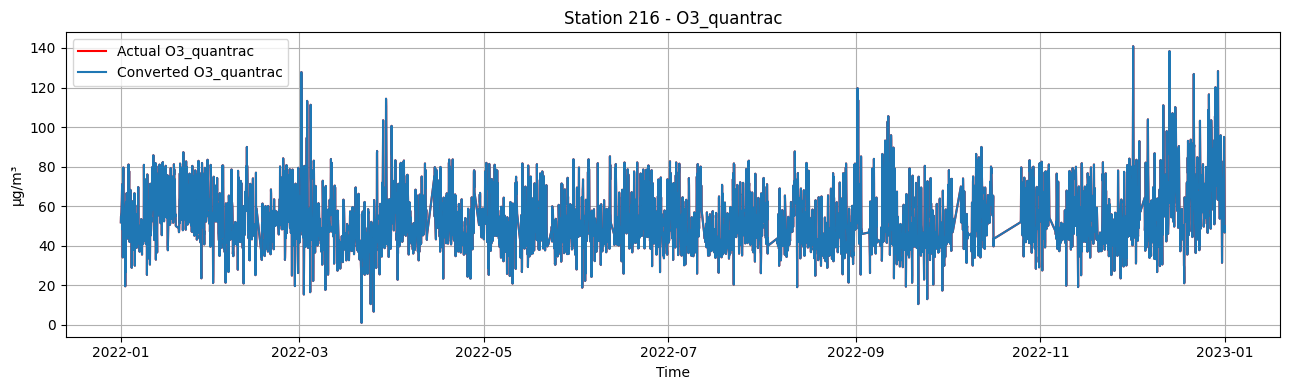

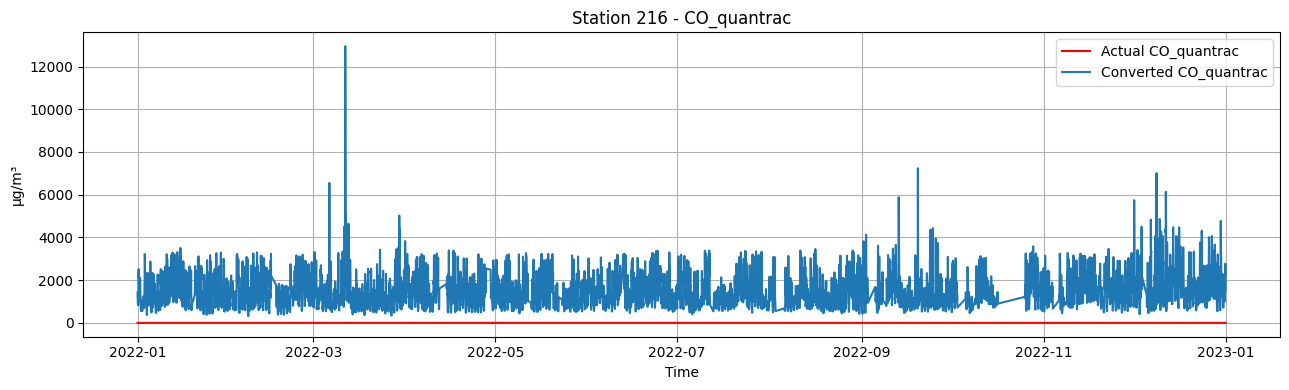

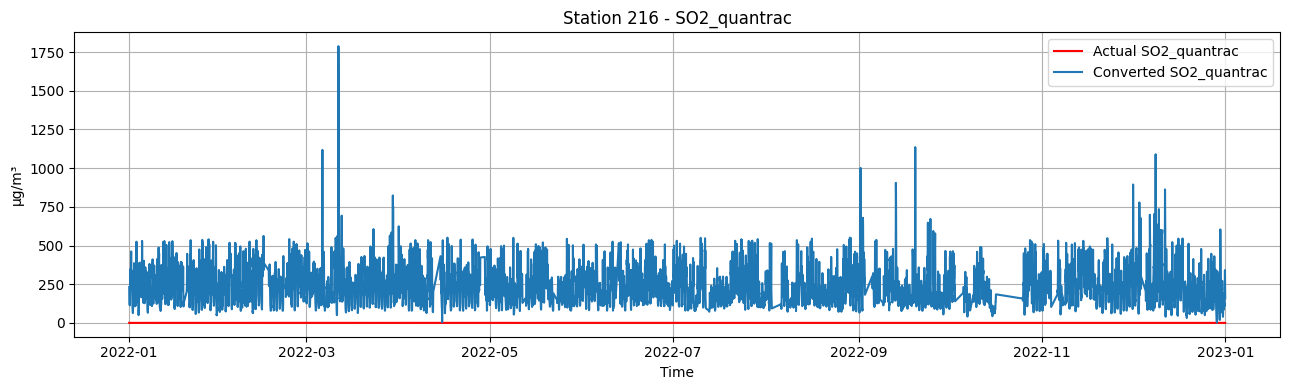

In [8]:
def plot_2_data(df1, target_col1, label1, df2, target_col2, label2, index, title, figsize=(13, 4)):
    plt.figure(figsize=figsize)
    plt.plot(index, df1[target_col1], label=label1, color="r")
    plt.plot(index, df2[target_col2], label=label2)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("µg/m³")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

for station in STATION_IDS:
    df_station = df_dropped[df_dropped["station_id"] == station]
    df_station_converted = df_converted[df_converted["station_id"] == station]
    for target_col in df_station.columns:
        if target_col not in ["date", "station_id", "Temperature_quantrac", "Humid_quantrac", "PM25_quantrac"]:
            plot_2_data(df_station, target_col, f"Actual {target_col}",
                        df_station_converted, target_col, f"Converted {target_col}",
                        df_station["date"], f"Station {station} - {target_col}")
                        #df_station.index, f"Station {station} - {target_col}")
    print("\n" + "=" * 150 + "\n")

## Ugly hack to remove outliers

In [9]:
test = copy.deepcopy(df_converted)

lenbefore = len(test)
print(f"Before: {lenbefore} records")

# 212 CO quantrac
test212 = test[test["station_id"] == 212]
test = test.drop(index=test212[test212["CO_quantrac"] > 4000].index)

# 213 CO quantrac
test213 = test[test["station_id"] == 213]
test = test.drop(index=test213[test213["CO_quantrac"] > 4000].index)

# 214 CO quantrac
test214 = test[test["station_id"] == 214]
test = test.drop(index=test214[test214["CO_quantrac"] > 4000].index)

# 215 NO2 quantrac
# 215 CO quantrac
test215 = test[test["station_id"] == 215]
test = test.drop(index=test215[test215["NO2_quantrac"] > 140].index)
test = test.drop(index=test215[test215["CO_quantrac"] > 2500].index)

# 216 CO quantrac
test216 = test[test["station_id"] == 216]
test = test.drop(index=test216[test216["CO_quantrac"] > 10000].index)

lenafter = len(test)
print(f"After: {lenafter} records")
print(f"Removed {lenbefore - lenafter} records")

df_converted = test.reset_index(drop=True)

Before: 7902 records
After: 7900 records
Removed 2 records


## Visualization after removing outliers

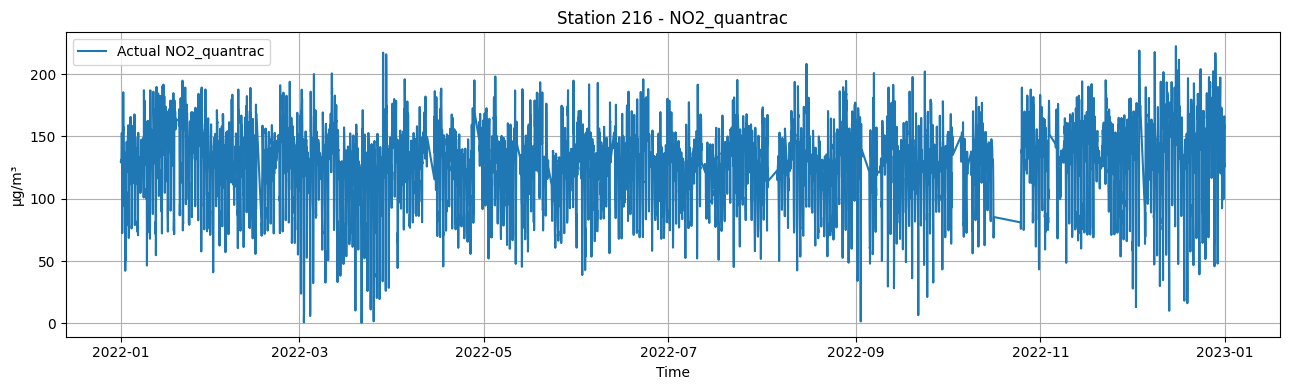

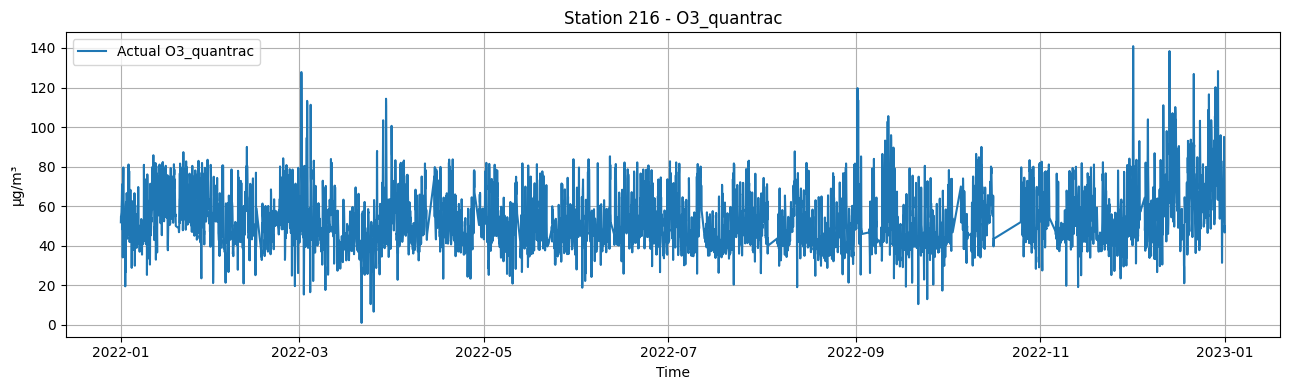

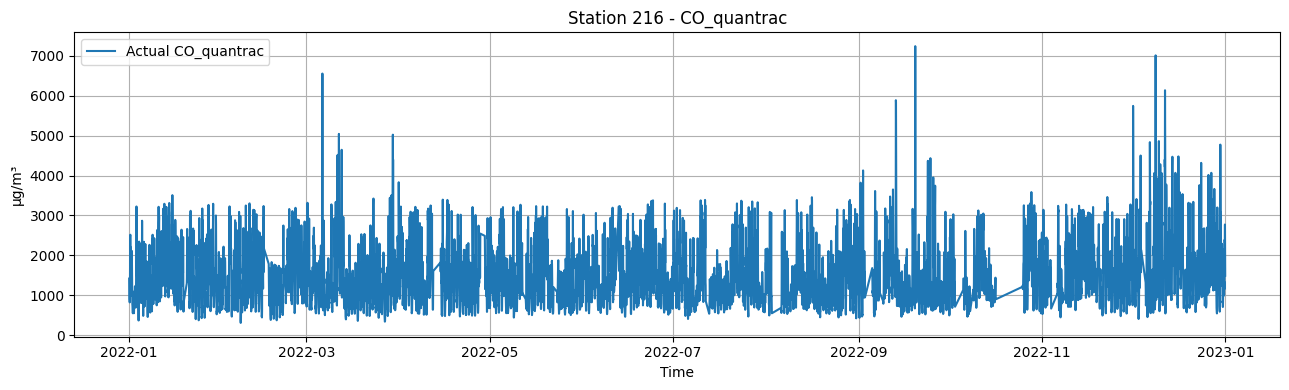

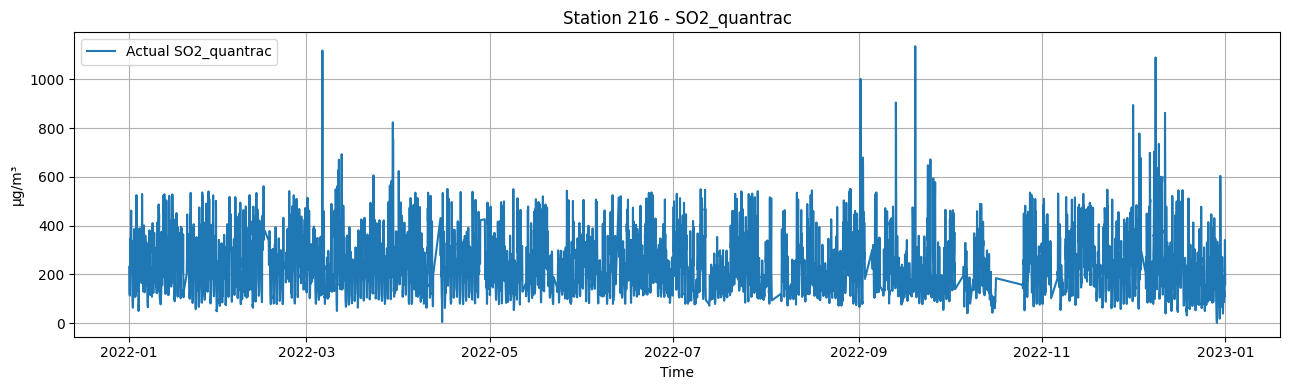

In [10]:
for station in STATION_IDS:
    df_station = df_converted[df_converted["station_id"] == station]
    for target_col in df_station.columns:
        if target_col not in ["date", "station_id", "Temperature_quantrac", "Humid_quantrac", "PM25_quantrac"]:
            plot_1_data(df_station, target_col, f"Actual {target_col}",
                        df_station["date"], f"Station {station} - {target_col}")
                        #df_station.index, f"Station {station} - {target_col}")
    print("\n" + "=" * 150 + "\n")

## Feature engineering

In [11]:
def add_time_features(df, time_col="date"):
    df = df.copy()
    df["hour"] = df[time_col].dt.hour
    df["dayofweek"] = df[time_col].dt.dayofweek
    df["month"] = df[time_col].dt.month
    return df

# Add lag features for all FEATURES including LABEL
def add_lag_features(df, group_col, target_cols, lag_steps):
    df = df.copy()
    df = df.sort_values(["station_id", "date"])

    for col in target_cols:
        for lag in lag_steps:
            df[f"{col}_lag{lag}"] = df.groupby(group_col)[col].shift(lag)
    return df

# Just add the rolling features for LABEL
def add_rolling_features(df, group_col, target_cols, windows):
    assert isinstance(target_cols, list), "target_cols should be a list"

    df = df.copy()
    df = df.sort_values(["station_id", "date"])

    for col in target_cols:
        for w in windows:
            df[f"{col}_roll{w}_mean"] = (
                df.groupby(group_col)[col]
                  .shift(1) # use the past, avoid leaking
                  .rolling(window=w, min_periods=1)
                  .mean()
                  .reset_index(level=0, drop=True)
            )
            df[f"{col}_roll{w}_std"] = (
                df.groupby(group_col)[col]
                  .shift(1)
                  .rolling(window=w, min_periods=1)
                  .std()
                  .reset_index(level=0, drop=True)
            )
    return df

# Add time features and lag feature for all gases
dftestno2 = add_time_features(df_converted)
dftestno2 = add_lag_features(df_converted, group_col="station_id", target_cols=BASE_FEATURE_COLS, lag_steps=[3, 6, 12, 24])
dftestno2 = add_rolling_features(df_converted, group_col="station_id", target_cols=["NO2_quantrac"], windows=[3, 6, 12, 24])
print(dftestno2.shape)
print(dftestno2.columns)
dftestno2

(7900, 17)
Index(['date', 'NO2_quantrac', 'PM25_quantrac', 'O3_quantrac', 'CO_quantrac',
       'SO2_quantrac', 'Temperature_quantrac', 'Humid_quantrac', 'station_id',
       'NO2_quantrac_roll3_mean', 'NO2_quantrac_roll3_std',
       'NO2_quantrac_roll6_mean', 'NO2_quantrac_roll6_std',
       'NO2_quantrac_roll12_mean', 'NO2_quantrac_roll12_std',
       'NO2_quantrac_roll24_mean', 'NO2_quantrac_roll24_std'],
      dtype='object')


,date,NO2_quantrac,PM25_quantrac,O3_quantrac,CO_quantrac,SO2_quantrac,Temperature_quantrac,Humid_quantrac,station_id,NO2_quantrac_roll3_mean,NO2_quantrac_roll3_std,NO2_quantrac_roll6_mean,NO2_quantrac_roll6_std,NO2_quantrac_roll12_mean,NO2_quantrac_roll12_std,NO2_quantrac_roll24_mean,NO2_quantrac_roll24_std
0,2022-01-01 00:00:00,129.905143,18.414899,51.895318,1419.872305,230.924024,29.117670,76.993087,216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-01-01 01:00:00,130.694080,19.490000,54.933333,1066.524000,171.173333,26.695000,61.735000,216,129.905143,NaN,129.905143,NaN,129.905143,NaN,129.905143,NaN
2,2022-01-01 02:00:00,128.999200,18.080000,55.033333,904.442933,139.296667,26.260000,63.083333,216,130.299612,0.557862,130.299612,0.557862,130.299612,0.557862,130.299612,0.557862
3,2022-01-01 03:00:00,131.227653,16.393333,55.700000,840.222133,118.336667,25.830000,64.401667,216,129.866141,0.848113,129.866141,0.848113,129.866141,0.848113,129.866141,0.848113
4,2022-01-01 04:00:00,130.725467,15.293333,55.916667,823.211267,116.590000,25.580000,65.158333,216,130.306978,1.163567,130.206519,0.971061,130.206519,0.971061,130.206519,0.971061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7895,2022-12-31 19:00:00,166.161013,41.450000,75.916667,2393.562733,276.846667,27.690000,67.290000,216,147.203467,18.862212,127.011378,25.478626,130.924249,19.684872,137.227097,24.338989
7896,2022-12-31 20:00:00,156.713627,50.530000,66.116667,2301.054200,272.916667,27.401667,68.026667,216,160.574187,6.599564,138.106564,25.643475,132.888531,21.995214,137.063625,24.120908
7897,2022-12-31 21:00:00,158.753760,55.055000,55.133333,2773.918067,341.036667,27.603333,66.965000,216,161.714569,4.748040,146.183400,21.686363,133.950447,22.869141,136.383581,23.278021
7898,2022-12-31 22:00:00,125.515280,26.078333,46.750000,1698.984200,198.683333,27.036667,63.361667,216,160.542800,4.971295,153.873133,14.338064,135.245147,23.859794,135.834314,22.546688


## Build supervised from time-series

In [12]:
# Reframe past future
def build_supervised_for_horizon(df, horizon_h, target_col):
    # Sort data by station_id then date
    df = df.copy()
    df = df.sort_values(["station_id", "date"])

    # Define target_name, which is the target_col plus horizon_h hour
    target_name = f"{target_col}_t_plus_{horizon_h}h"
    df[target_name] = df.groupby("station_id")[target_col].shift(-horizon_h)

    # Dropna after shifting
    df = df.dropna().reset_index(drop=True)

    # Define label, feature and meta columns
    label_cols = [target_name]
    meta_cols = ["date", "station_id"]
    feature_cols = [c for c in df.columns if c not in label_cols + meta_cols + [target_col]]

    # Get the X, y and meta data
    X = df[meta_cols + feature_cols]
    y = df[meta_cols + label_cols]

    return X, y

# Example
Xdummy, ydummy = build_supervised_for_horizon(dftestno2, horizon_h=72, target_col="NO2_quantrac")
print("Horizon 1h:", Xdummy.shape, ydummy.shape)
print(Xdummy.columns)
print(ydummy.columns)
display(Xdummy)
display(ydummy)

Horizon 1h: (7826, 16) (7826, 3)
Index(['date', 'station_id', 'PM25_quantrac', 'O3_quantrac', 'CO_quantrac',
       'SO2_quantrac', 'Temperature_quantrac', 'Humid_quantrac',
       'NO2_quantrac_roll3_mean', 'NO2_quantrac_roll3_std',
       'NO2_quantrac_roll6_mean', 'NO2_quantrac_roll6_std',
       'NO2_quantrac_roll12_mean', 'NO2_quantrac_roll12_std',
       'NO2_quantrac_roll24_mean', 'NO2_quantrac_roll24_std'],
      dtype='object')
Index(['date', 'station_id', 'NO2_quantrac_t_plus_72h'], dtype='object')


,date,station_id,PM25_quantrac,O3_quantrac,CO_quantrac,SO2_quantrac,Temperature_quantrac,Humid_quantrac,NO2_quantrac_roll3_mean,NO2_quantrac_roll3_std,NO2_quantrac_roll6_mean,NO2_quantrac_roll6_std,NO2_quantrac_roll12_mean,NO2_quantrac_roll12_std,NO2_quantrac_roll24_mean,NO2_quantrac_roll24_std
0,2022-01-01 02:00:00,216,18.080000,55.033333,904.442933,139.296667,26.260000,63.083333,130.299612,0.557862,130.299612,0.557862,130.299612,0.557862,130.299612,0.557862
1,2022-01-01 03:00:00,216,16.393333,55.700000,840.222133,118.336667,25.830000,64.401667,129.866141,0.848113,129.866141,0.848113,129.866141,0.848113,129.866141,0.848113
2,2022-01-01 04:00:00,216,15.293333,55.916667,823.211267,116.590000,25.580000,65.158333,130.306978,1.163567,130.206519,0.971061,130.206519,0.971061,130.206519,0.971061
3,2022-01-01 05:00:00,216,15.431667,56.900000,869.083267,113.096667,25.320000,65.726667,130.317440,1.168916,130.310309,0.872399,130.310309,0.872399,130.310309,0.872399
4,2022-01-01 06:00:00,216,16.831667,58.566667,1222.488800,155.453333,25.036667,67.110000,131.656604,1.204338,130.761373,1.352634,130.761373,1.352634,130.761373,1.352634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7821,2022-12-28 17:00:00,216,29.516667,105.483333,2638.404533,282.960000,31.451667,47.931667,99.213253,35.890417,79.193791,33.369388,128.680102,56.847274,149.965321,46.466557
7822,2022-12-28 18:00:00,216,29.155000,102.333333,2795.898400,324.443333,30.571667,52.196667,121.884889,52.083772,93.699662,48.484262,126.940758,55.217495,150.509356,46.573165
7823,2022-12-28 19:00:00,216,32.163333,89.283333,2518.755067,313.526667,29.625000,58.043333,159.214098,20.857906,114.184693,53.684851,127.581569,55.785534,151.632738,46.865551
7824,2022-12-28 20:00:00,216,37.030000,116.950000,2530.796467,270.733333,28.140000,71.948333,173.348560,6.878694,136.280907,46.722462,128.130836,56.290097,152.433098,47.162243


,date,station_id,NO2_quantrac_t_plus_72h
0,2022-01-01 02:00:00,216,111.705147
1,2022-01-01 03:00:00,216,146.795440
2,2022-01-01 04:00:00,216,165.501893
3,2022-01-01 05:00:00,216,151.723147
4,2022-01-01 06:00:00,216,154.799040
...,...,...,...
7821,2022-12-28 17:00:00,216,166.161013
7822,2022-12-28 18:00:00,216,156.713627
7823,2022-12-28 19:00:00,216,158.753760
7824,2022-12-28 20:00:00,216,125.515280


## Split train/validation/test for each station

In [13]:
def train_test_validation_split(X, y, train_ratio=0.7, val_ratio=0.15):
    assert (X["date"].equals(y["date"]) and X["station_id"].equals(y["station_id"])), "X and y should have the same metadata values"

    X_train, y_train, X_val, y_val, X_test, y_test = [], [], [], [], [], []
    meta_train, meta_val, meta_test = [], [], []

    meta_cols = ["date", "station_id"]
    
    for station in list(sorted(X["station_id"].unique())):
        X_station = X[X["station_id"] == station]
        y_station = y[y["station_id"] == station]
        meta = X_station[meta_cols]

        X_station = X_station.drop(columns=meta_cols)
        y_station = y_station.drop(columns=meta_cols)
    
        n = len(X_station)
        train_end = int(n * train_ratio)
        val_end = int(n * (train_ratio + val_ratio))
    
        X_train.append(X_station.iloc[:train_end])
        y_train.append(y_station.iloc[:train_end])
        meta_train.append(meta.iloc[:train_end])
    
        X_val.append(X_station.iloc[train_end:val_end])
        y_val.append(y_station.iloc[train_end:val_end])
        meta_val.append(meta.iloc[train_end:val_end])
    
        X_test.append(X_station.iloc[val_end:])
        y_test.append(y_station.iloc[val_end:])
        meta_test.append(meta.iloc[val_end:])

    X_train = pd.concat(X_train, axis=0)
    X_val = pd.concat(X_val, axis=0)
    X_test = pd.concat(X_test, axis=0)
    
    y_train = pd.concat(y_train, axis=0)
    y_val = pd.concat(y_val, axis=0)
    y_test = pd.concat(y_test, axis=0)
    
    meta_train = pd.concat(meta_train, axis=0)
    meta_val = pd.concat(meta_val, axis=0)
    meta_test = pd.concat(meta_test, axis=0)

    return (X_train, y_train, meta_train, X_val, y_val, meta_val, X_test, y_test, meta_test)

# Example
(X_train_dummy, y_train_dummy, meta_train_dummy,
 X_val_dummy, y_val_dummy, meta_val_dummy,
 X_test_dummy, y_test_dummy, meta_test_dummy) = train_test_validation_split(Xdummy, ydummy)
display(X_test_dummy)

,PM25_quantrac,O3_quantrac,CO_quantrac,SO2_quantrac,Temperature_quantrac,Humid_quantrac,NO2_quantrac_roll3_mean,NO2_quantrac_roll3_std,NO2_quantrac_roll6_mean,NO2_quantrac_roll6_std,NO2_quantrac_roll12_mean,NO2_quantrac_roll12_std,NO2_quantrac_roll24_mean,NO2_quantrac_roll24_std
6652,12.075000,51.000000,989.115000,131.000000,26.275000,85.375000,134.889431,5.286519,132.279107,5.545865,120.752353,14.040468,117.235409,11.525616
6653,10.703333,48.016667,981.851933,130.563333,26.431667,84.385000,135.286996,5.734863,134.983591,4.279312,124.105496,13.312929,118.003075,12.396012
6654,10.550000,47.750000,888.387733,117.026667,26.313333,84.365000,133.717662,5.595754,134.790040,4.377140,126.030544,12.643805,118.547578,12.742889
6655,12.041667,44.883333,1150.431533,157.200000,26.361667,82.775000,134.376782,4.793262,134.633107,4.521935,128.468242,10.053033,118.973776,12.982993
6656,15.856667,48.500000,2167.260867,312.653333,26.490000,82.256667,130.735929,1.790508,133.011462,4.544391,128.837036,9.974272,119.356954,13.140383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7821,29.516667,105.483333,2638.404533,282.960000,31.451667,47.931667,99.213253,35.890417,79.193791,33.369388,128.680102,56.847274,149.965321,46.466557
7822,29.155000,102.333333,2795.898400,324.443333,30.571667,52.196667,121.884889,52.083772,93.699662,48.484262,126.940758,55.217495,150.509356,46.573165
7823,32.163333,89.283333,2518.755067,313.526667,29.625000,58.043333,159.214098,20.857906,114.184693,53.684851,127.581569,55.785534,151.632738,46.865551
7824,37.030000,116.950000,2530.796467,270.733333,28.140000,71.948333,173.348560,6.878694,136.280907,46.722462,128.130836,56.290097,152.433098,47.162243


## Metrics

In [16]:
def compute_metrics(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    # Mean Bias Error
    mbe = np.mean(y_pred - y_true)

    # MNBE
    yt_nonzero = np.where(y_true == 0, np.nan, y_true)
    mnbe = np.nanmean((y_pred - yt_nonzero) / yt_nonzero) * 100.0

    # Pearson r (with standard deviation check)
    if np.std(y_true) < 1e-6 or np.std(y_pred) < 1e-6:
        r = np.nan
    else:
        r = np.corrcoef(y_true.T, y_pred.T)[0, 1]

    return {
        "RMSE": rmse,
        "MAE": mae,
        "MBE": mbe,
        "MNBE": mnbe,
        "r": r,
        "n_samples": len(y_true),
    }

# LightGBM model

## Define model

In [17]:
def train_lgbm_for_horizon(df_feat,
                           horizon_h,
                           target_col,
                           learning_rate=0.05,
                           n_estimators=2000,
                           early_stopping_rounds=100):

    # Build supervised dataset
    X, y = build_supervised_for_horizon(df_feat, horizon_h=horizon_h, target_col=target_col)

    # Split train validation test
    (X_train, y_train, meta_train, X_val, y_val, meta_val, X_test, y_test, meta_test) = train_test_validation_split(X, y)

    # Remove outliers for test data
    #removed_indices = get_outliers_indices(y_test, meta_test, f"{target_col}_t_plus_{horizon_h}h")
    #print(f"Removed indices: {removed_indices}")
    #X_test = X_test.drop(index=removed_indices)
    #y_test = y_test.drop(index=removed_indices)
    #meta_test = meta_test.drop(index=removed_indices)

    # Dataset cho LightGBM
    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

    params = {
        "objective": "regression",
        "metric": "rmse",
        "learning_rate": learning_rate,
        "num_leaves": 63,
        "feature_fraction": 0.9,
        "bagging_fraction": 0.8,
        "bagging_freq": 1,
        "verbosity": -1,
        "device": "cuda",
        "seed": RANDOM_STATE,
    }

    # Early stopping dùng callback (tương thích nhiều version LightGBM)
    callbacks = [
        lgb.early_stopping(stopping_rounds=early_stopping_rounds),
        lgb.log_evaluation(period=100),
    ]
    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=n_estimators,
        valid_sets=[lgb_train, lgb_val],
        valid_names=["train", "val"],
        callbacks=callbacks,
    )

    # Prediction
    y_pred = np.expand_dims(model.predict(X_test, num_iteration=model.best_iteration), axis=-1)
    metrics_overall = compute_metrics(y_test, y_pred)

    # Metrics for each station
    df_test_res = meta_test.copy()
    df_test_res["y_true"] = y_test.values
    df_test_res["y_pred"] = y_pred

    rows = []
    for sid, grp in df_test_res.groupby("station_id"):
        m = compute_metrics(grp["y_true"], grp["y_pred"])
        rows.append({"station": int(sid), "horizon_h": horizon_h,**m})
    metrics_by_station = pd.DataFrame(rows)

    return model, metrics_overall, metrics_by_station, (
        X_train, y_train, X_val, y_val, X_test, y_test, meta_test
    )

## Reference

In [18]:
def plot_timeseries_example(df, model, horizon_h, station_id, target_col, n_points=300):
    # Prepare data for reference
    X, y = build_supervised_for_horizon(df, horizon_h, target_col)
    (_, _, _,
     _, _, _,
     X_test, y_test, meta_test) = train_test_validation_split(X, y)

    # Remove outliers for test data
    #removed_indices = get_outliers_indices(y_test, meta_test, f"{target_col}_t_plus_{horizon_h}h")
    #print(f"Removed indices: {removed_indices}")
    #X_test = X_test.drop(index=removed_indices)
    #y_test = y_test.drop(index=removed_indices)
    #meta_test = meta_test.drop(index=removed_indices)

    # Get the data of station
    mask = (meta_test["station_id"] == station_id)
    X_test_sid = X_test[mask]
    y_test_sid = y_test[mask]
    meta_sid = meta_test[mask]
    if len(X_test_sid) == 0:
        print(f"No test sample for station {station_id}")
        return
    
    # Prediction
    y_pred_sid = model.predict(X_test_sid, num_iteration=getattr(model, "best_iteration", None))

    # Plotting
    X_plot = meta_sid.iloc[-n_points:]
    y_true_plot = y_test_sid.iloc[-n_points:]
    y_pred_plot = y_pred_sid[-n_points:]

    plt.figure(figsize=(14, 5))
    plt.plot(X_plot["date"], y_true_plot, label=f"Actual {target_col}", linewidth=1.5)
    plt.plot(X_plot["date"], y_pred_plot, label=f"Predicted {target_col} (LightGBM)", linestyle="--")
    #plt.plot(X_plot.index, y_true_plot, label=f"Actual {target_col}", linewidth=1.5)
    #plt.plot(X_plot.index, y_pred_plot, label=f"Predicted {target_col} (LightGBM)", linestyle="--")
    plt.title(f"Station {station_id} - Horizon {horizon_h}h")
    plt.xlabel("Time")
    plt.ylabel(f"{target_col} (µg/m³)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(LIGHTGBM_DIR, f"{target_col}_lightgbm_{horizon_h}h_{station_id}_{n_points}.png"))
    plt.show()

## Add time and lags features

In [19]:
# Add time features and lag feature for all gases
df_time_feats = add_time_features(df_converted)
df_lag_feats = add_lag_features(df_time_feats, group_col="station_id", target_cols=BASE_FEATURE_COLS, lag_steps=LAG_STEPS)

## Training for SO2

In [20]:
label = "SO2_quantrac"

# Add rolling features for LABEL
df_so2 = add_rolling_features(df_lag_feats, group_col="station_id", target_cols=[label], windows=ROLL_WINDOWS)

print(df_so2.columns)

# Start running model
so2_all_metrics = []
so2_models_by_h = {}
for h in HORIZONS:
    print(f"\n===== Training LightGBM for horizon = {h}h, target_col = {label} =====")
    model_h, metrics_overall, metrics_by_station, _ = train_lgbm_for_horizon(df_so2, horizon_h=h, target_col=label)
    so2_models_by_h[h] = model_h
    model_h.save_model(os.path.join(LIGHTGBM_DIR, f"{label}_lightgbm_{h}h"))
    print("Overall test metrics:", metrics_overall)
    so2_all_metrics.append(metrics_by_station)

# Metrics table
so2_df_metrics_all = pd.concat(so2_all_metrics, ignore_index=True)
so2_df_metrics_all = so2_df_metrics_all.sort_values(["station", "horizon_h"]).reset_index(drop=True)
so2_df_metrics_all.to_csv(os.path.join(LIGHTGBM_DIR, f"{label}_metrics.csv"))
so2_df_metrics_all

Index(['date', 'NO2_quantrac', 'PM25_quantrac', 'O3_quantrac', 'CO_quantrac',
       'SO2_quantrac', 'Temperature_quantrac', 'Humid_quantrac', 'station_id',
       'hour', 'dayofweek', 'month', 'NO2_quantrac_lag3', 'NO2_quantrac_lag6',
       'NO2_quantrac_lag12', 'NO2_quantrac_lag24', 'PM25_quantrac_lag3',
       'PM25_quantrac_lag6', 'PM25_quantrac_lag12', 'PM25_quantrac_lag24',
       'O3_quantrac_lag3', 'O3_quantrac_lag6', 'O3_quantrac_lag12',
       'O3_quantrac_lag24', 'CO_quantrac_lag3', 'CO_quantrac_lag6',
       'CO_quantrac_lag12', 'CO_quantrac_lag24', 'SO2_quantrac_lag3',
       'SO2_quantrac_lag6', 'SO2_quantrac_lag12', 'SO2_quantrac_lag24',
       'Temperature_quantrac_lag3', 'Temperature_quantrac_lag6',
       'Temperature_quantrac_lag12', 'Temperature_quantrac_lag24',
       'Humid_quantrac_lag3', 'Humid_quantrac_lag6', 'Humid_quantrac_lag12',
       'Humid_quantrac_lag24', 'SO2_quantrac_roll3_mean',
       'SO2_quantrac_roll3_std', 'SO2_quantrac_roll6_mean',
       'SO2

,station,horizon_h,RMSE,MAE,MBE,MNBE,r,n_samples
0,216,1,95.922013,72.100732,29.034076,40.622333,0.704114,1182
1,216,24,117.304942,89.430542,8.012763,46.833023,0.419187,1178
2,216,48,117.007047,87.321836,-3.201342,39.337476,0.426950,1175
3,216,72,119.697635,89.309193,-5.667730,42.533076,0.397182,1171


station_id = 216
hour = 1


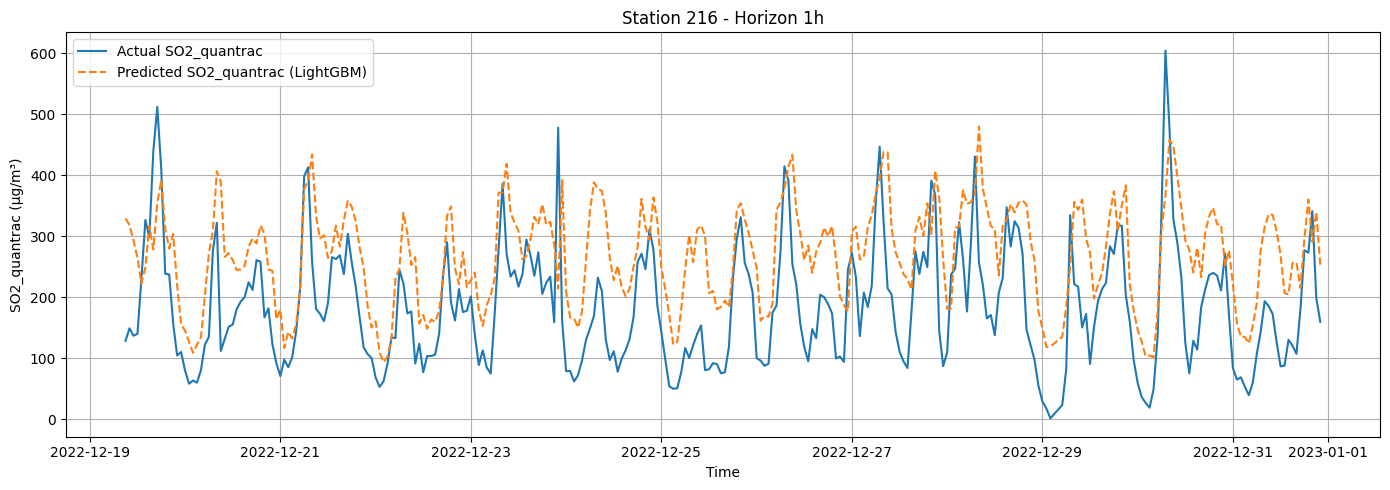

hour = 24


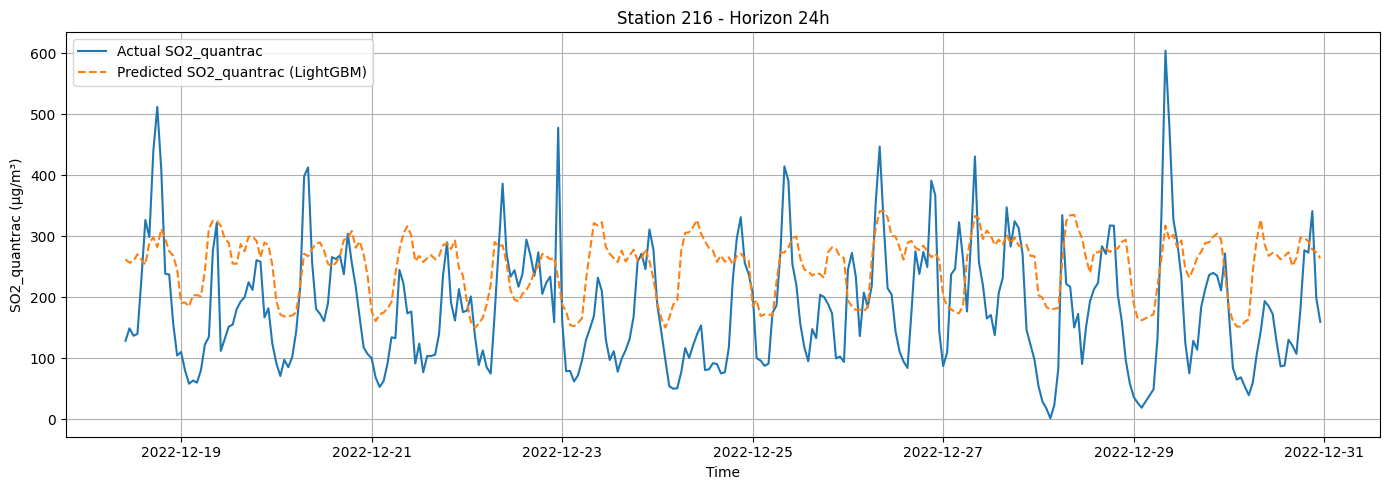

hour = 48


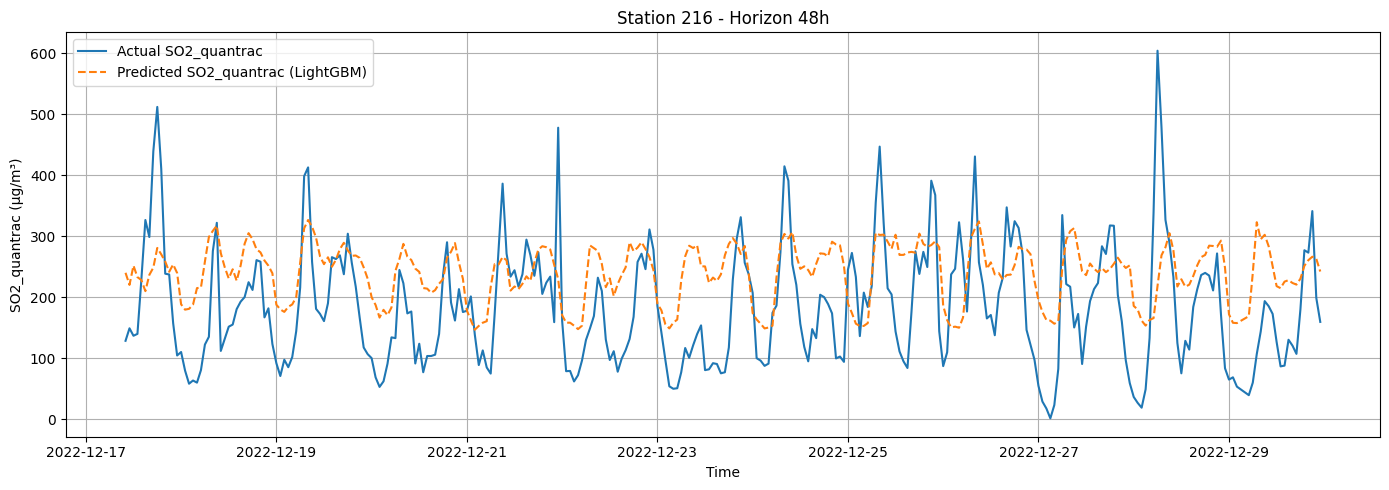

hour = 72


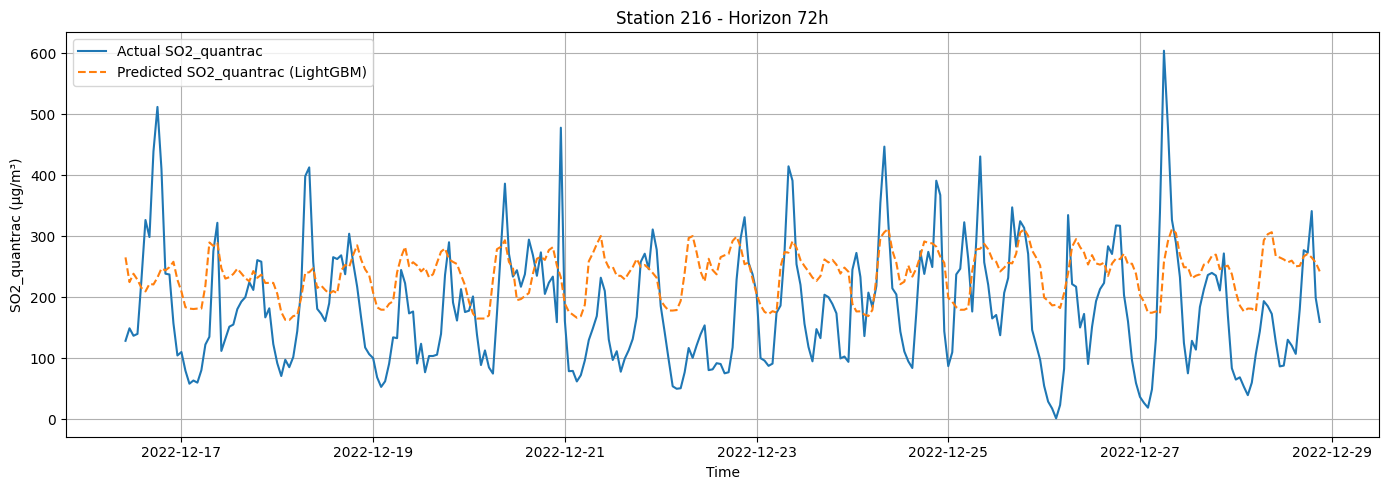

In [21]:
# Reference
for station_id in STATION_IDS:
    print(f"station_id = {station_id}")
    for hour in HORIZONS:
        print(f"hour = {hour}")
        plot_timeseries_example(df_so2, so2_models_by_h[hour], horizon_h=hour, station_id=station_id, target_col=label)